Model Building - Base Model

In [1]:
import pandas as pd
import joblib

import warnings

warnings.filterwarnings("ignore")

from afl_match_outcome_model.config import match_summary_file_path
from afl_match_outcome_model.data_preparation.match_summary_preprocessor import MatchSummaryPreprocessor

from afl_match_outcome_model.modelling_data_contract import ModellingDataContract
from afl_match_outcome_model.modelling.hyperparameter_tuning import (
    XGBHyperparameterTuner,
    XGBCVHyperparameterTuner
)
from afl_match_outcome_model.modelling.supermodel import SuperXGBClassifier
from afl_match_outcome_model.modelling.optuna_xgb_param_grid import OptunaXGBParamGrid

from afl_match_outcome_model.evaluation.model_evaluation import XGBClassifierEvaluator


from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

pd.options.display.max_rows = 100
pd.options.display.max_columns = 999

%load_ext autoreload
%autoreload 2

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
RESPONSE = ModellingDataContract.RESPONSE

Load Data

In [3]:
data = pd.read_csv(match_summary_file_path)
data = data.sort_values(by = ['Date']).reset_index(drop = True)
data.head()

,Home_Team,Away_Team,Q4_Score,Margin,Total Game Score,Home Win,Venue,City,Date,Attendance,Temperature,Weather_Type,Year,Round_ID,Match_ID,Season
0,Richmond,Melbourne,14.10.94 - 13.14.92,2,186,1.0,M.C.G.,Melbourne,2000-03-08 19:40:00,41648,NaN,NaN,2000,200001,200001_Richmond_Melbourne,NaN
1,Essendon,Port Adelaide,24.12.156 - 8.14.62,94,218,1.0,Docklands,Melbourne,2000-03-09 20:15:00,43012,NaN,NaN,2000,200001,200001_Essendon_PortAdelaide,NaN
2,North Melbourne,West Coast,16.15.111 - 24.10.154,-43,265,0.0,M.C.G.,Melbourne,2000-03-10 19:40:00,20580,NaN,NaN,2000,200001,200001_NorthMelbourne_WestCoast,NaN
3,Fremantle,Geelong,16.11.107 - 19.15.129,-22,236,0.0,Subiaco,Perth,2000-03-11 20:40:00,19777,NaN,NaN,2000,200001,200001_Fremantle_Geelong,NaN
4,St Kilda,Sydney,15.10.100 - 21.8.134,-34,234,0.0,Docklands,Melbourne,2000-03-12 19:40:00,31440,NaN,NaN,2000,200001,200001_StKilda_Sydney,NaN


Preprocessing

In [4]:
match_preprocessor = MatchSummaryPreprocessor(
    categorical_features=['Venue', 'City', 'Opponent' ,'Team'],
    rolling_cols=['Team_Score', 'Opp_Score', 'Team_Goals', 'Opp_Goals'],
    rolling=[1, 3, 5, 10, 20],
    extra_features=['Home']
)
match_preprocessor.fit(data)

MatchSummaryPreprocessor(categorical_features=['Venue', 'City', 'Opponent',
                                               'Team'],
                         extra_features=['Home'], rolling=[1, 3, 5, 10, 20],
                         rolling_cols=['Team_Score', 'Opp_Score', 'Team_Goals',
                                       'Opp_Goals'])

In [5]:
X = match_preprocessor.transform(data)
y = match_preprocessor.get_response(data)

Train Test Split

In [6]:
X_train = X[X['Year'] < 2022]
X_cal = X[X['Year'] == 2022]
X_test = X[X['Year'] == 2023]

In [7]:
X_test.head()

,Home,Team_Score_rolling_1,Opp_Score_rolling_1,Team_Goals_rolling_1,Opp_Goals_rolling_1,Team_Score_rolling_3,Opp_Score_rolling_3,Team_Goals_rolling_3,Opp_Goals_rolling_3,Team_Score_rolling_5,Opp_Score_rolling_5,Team_Goals_rolling_5,Opp_Goals_rolling_5,Team_Score_rolling_10,Opp_Score_rolling_10,Team_Goals_rolling_10,Opp_Goals_rolling_10,Team_Score_rolling_20,Opp_Score_rolling_20,Team_Goals_rolling_20,Opp_Goals_rolling_20,Venue_Adelaide Oval,Venue_Bellerive Oval,Venue_Blacktown,Venue_Carrara,Venue_Cazalys Stadium,Venue_Docklands,Venue_Eureka Stadium,Venue_Football Park,Venue_Gabba,Venue_Jiangwan Stadium,Venue_Kardinia Park,Venue_M.C.G.,Venue_Manuka Oval,Venue_Marrara Oval,Venue_Norwood Oval,Venue_Perth Stadium,Venue_Princes Park,Venue_Riverway Stadium,Venue_S.C.G.,Venue_Stadium Australia,Venue_Subiaco,Venue_Sydney Showground,Venue_Traeger Park,Venue_W.A.C.A.,Venue_Wellington,Venue_York Park,City_Adelaide,City_Alice Springs,City_Ballarat,City_Brisbane,City_Cairns,City_Canberra,City_Darwin,City_Geelong,City_Gold Coast,City_Hobart,City_Launceston,City_Melbourne,City_Perth,City_Shanghai,City_Sydney,City_Townsville,City_Wellington,Opponent_Adelaide,Opponent_Brisbane Lions,Opponent_Carlton,Opponent_Collingwood,Opponent_Essendon,Opponent_Fremantle,Opponent_Geelong,Opponent_Gold Coast,Opponent_Greater Western Sydney,Opponent_Hawthorn,Opponent_Melbourne,Opponent_North Melbourne,Opponent_Port Adelaide,Opponent_Richmond,Opponent_St Kilda,Opponent_Sydney,Opponent_West Coast,Opponent_Western Bulldogs,Team_Adelaide,Team_Brisbane Lions,Team_Carlton,Team_Collingwood,Team_Essendon,Team_Fremantle,Team_Geelong,Team_Gold Coast,Team_Greater Western Sydney,Team_Hawthorn,Team_Melbourne,Team_North Melbourne,Team_Port Adelaide,Team_Richmond,Team_St Kilda,Team_Sydney,Team_West Coast,Team_Western Bulldogs,Day,Month,Year
8564,0,74.0,75.0,10.0,11.0,76.333333,89.333333,10.666667,13.000000,74.8,81.2,10.6,11.8,77.0,76.8,10.9,11.1,82.70,77.40,11.90,11.2,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,16,3,2023
8565,1,104.0,106.0,16.0,16.0,124.333333,82.666667,19.000000,12.000000,117.2,83.2,17.6,12.0,103.2,83.6,15.2,12.1,100.00,79.75,14.70,11.4,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,16,3,2023
8566,0,94.0,95.0,14.0,14.0,81.666667,77.333333,11.666667,11.333333,74.0,76.6,10.6,11.0,81.3,79.7,12.0,11.6,81.30,78.15,11.80,11.4,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,17,3,2023
8567,1,133.0,52.0,20.0,8.0,110.333333,57.666667,16.333333,8.333333,116.2,55.6,17.2,8.2,106.7,62.1,15.7,9.1,99.90,61.45,14.55,8.9,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Fal

In [8]:
y_train = y.loc[X_train.index]
y_cal = y.loc[X_cal.index]
y_test = y.loc[X_test.index]

Optuna Hyperparameter Tuning Class - HyperParameterTuner & XGBHyperparameterTuner

Time Series Cross Validation

In [10]:
xgb_tuner = XGBCVHyperparameterTuner(
    X_train, y_train, monotonicity_constraints={}, nfolds=5
)

In [11]:
xgb_tuner.tune_hyperparameters()

[I 2024-01-13 13:26:40,292] A new study created in memory with name: no-name-4af1fc42-ee41-4ad4-b697-77a05011b92d
[I 2024-01-13 13:26:40,551] Trial 0 finished with value: 0.6682882122284065 and parameters: {'max_depth': 2, 'min_child_weight': 35, 'eta': 0.0863736986167276, 'gamma': 0.3670364120187924, 'lambda': 0.006042619787617939, 'alpha': 0.02828786990058156, 'subsample': 0.7164608664909515, 'colsample_bytree': 0.41496300866891395}. Best is trial 0 with value: 0.6682882122284065.
[I 2024-01-13 13:26:40,760] Trial 1 finished with value: 0.6590162581772161 and parameters: {'max_depth': 20, 'min_child_weight': 54, 'eta': 0.43338815287985566, 'gamma': 0.011272213539267103, 'lambda': 0.9099770682671815, 'alpha': 1.2248399218321324, 'subsample': 0.31531934842135634, 'colsample_bytree': 0.576623062454308}. Best is trial 1 with value: 0.6590162581772161.
[I 2024-01-13 13:26:41,082] Trial 2 finished with value: 0.6798592107500766 and parameters: {'max_depth': 13, 'min_child_weight': 20, 'eta

Number of finished trials:  100
Best trial:
  Value: 0.6401936139806282
  Params: 
    max_depth: 3
    min_child_weight: 15
    eta: 0.3766982840432364
    gamma: 0.018120136599935742
    lambda: 0.011676111012036718
    alpha: 3.3240055981490713
    subsample: 0.793984617641575
    colsample_bytree: 0.603651896375416


In [12]:
params = xgb_tuner.get_best_params()
params

{'max_depth': 3,
 'min_child_weight': 15,
 'eta': 0.3766982840432364,
 'gamma': 0.018120136599935742,
 'lambda': 0.011676111012036718,
 'alpha': 3.3240055981490713,
 'subsample': 0.793984617641575,
 'colsample_bytree': 0.603651896375416}

Training Model - SuperXGBClassifier class for training and predictions

In [13]:
params["objective"] = OptunaXGBParamGrid.error
params["num_rounds"] = 1000
params["early_stopping_rounds"] = 10
params["verbosity"] = 1
params["monotone_constraints"] = {}

In [14]:
super_xgb = SuperXGBClassifier(
    X_train=X_train, y_train=y_train,
    X_test=X_test, y_test=y_test,
    X_cal=X_cal, y_cal=y_cal,
    params=params
)

In [15]:
super_xgb.fit()

[0]	validation_0-logloss:0.67035	validation_1-logloss:0.67610
[1]	validation_0-logloss:0.65857	validation_1-logloss:0.66458
[2]	validation_0-logloss:0.65010	validation_1-logloss:0.65600
[3]	validation_0-logloss:0.64492	validation_1-logloss:0.65521
[4]	validation_0-logloss:0.64029	validation_1-logloss:0.65703
[5]	validation_0-logloss:0.63663	validation_1-logloss:0.65740
[6]	validation_0-logloss:0.63401	validation_1-logloss:0.65965
[7]	validation_0-logloss:0.63142	validation_1-logloss:0.66134
[8]	validation_0-logloss:0.62907	validation_1-logloss:0.66166
[9]	validation_0-logloss:0.62662	validation_1-logloss:0.66439
[10]	validation_0-logloss:0.62473	validation_1-logloss:0.66369
[11]	validation_0-logloss:0.62317	validation_1-logloss:0.66546
[12]	validation_0-logloss:0.62167	validation_1-logloss:0.66509


In [16]:
super_xgb.calibrate()

In [17]:
super_xgb.xgb_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.603651896375416, device=None,
              early_stopping_rounds=10, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.018120136599935742,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3766982840432364,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=15, missing=nan, monotone_constraints={},
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [18]:
preds = super_xgb.predict(X)
train_preds = super_xgb.predict(X_train)
test_preds = super_xgb.predict(X_test)

In [19]:
preds = super_xgb.predict(X)
train_preds = super_xgb.predict(X_train)
cal_preds = super_xgb.predict(X_cal)
test_preds = super_xgb.predict(X_test)

In [20]:
probas = super_xgb.predict_proba(X)[:, 1]
train_probas = super_xgb.predict_proba(X_train)[:, 1]
test_probas = super_xgb.predict_proba(X_test)[:, 1]
cal_probas = super_xgb.predict_proba(X_cal)[:, 1]

In [21]:
cal_probas = super_xgb.predict_proba(X, calibrate=True)
train_cal_probas = super_xgb.predict_proba(X_train, calibrate=True)
test_cal_probas = super_xgb.predict_proba(X_test, calibrate=True)
cal_cal_probas = super_xgb.predict_proba(X_cal, calibrate=True)

Check Average Predictions

In [22]:
y.mean(), probas.mean(), cal_probas.mean()

(0.5016688918558078, 0.50367856, 0.47105308369306903)

In [23]:
y_train.mean(), train_probas.mean(), train_cal_probas.mean()

(0.501840490797546, 0.5018924, 0.46784660540534256)

In [24]:
y_test.mean(), test_probas.mean(), test_cal_probas.mean()

(0.5, 0.52196324, 0.5044211614702102)

In [25]:
y_cal.mean(), cal_probas.mean(), cal_cal_probas.mean()

(0.5, 0.47105308369306903, 0.5000017142908049)

Model Evaluation

In [26]:
training_data = pd.concat([X_train, y_train], axis=1)
training_data["xgb_preds"] = train_preds
training_data["xgb_probas"] = train_probas
training_data["xgb_cal_probas"] = train_cal_probas
training_data['baseline'] = y_train.mean()
training_data['baseline_label'] = 1

train_xgb_evals = XGBClassifierEvaluator(
    model=super_xgb.xgb_model,
    data=training_data,
    actual_name=RESPONSE,
    expected_name="xgb_cal_probas",
    expected_label_name="xgb_preds",
    compare_name="baseline",
    compare_label_name="baseline_label"
)

In [27]:
test_data = pd.concat([X_test, y_test], axis=1)
test_data["xgb_preds"] = test_preds
test_data["xgb_probas"] = test_probas
test_data["xgb_cal_probas"] = test_cal_probas
test_data['baseline'] = y_train.mean()
test_data['baseline_label'] = 1

test_xgb_evals = XGBClassifierEvaluator(
    model=super_xgb.xgb_model,
    data=test_data,
    actual_name=RESPONSE,
    expected_name="xgb_cal_probas",
    expected_label_name="xgb_preds",
    compare_name="baseline",
    compare_label_name="baseline_label"
)

baseline_xgb_evals = XGBClassifierEvaluator(
    model=super_xgb.xgb_model,
    data=test_data,
    actual_name=RESPONSE,
    expected_name="baseline",
    expected_label_name="baseline_label",
)


Model Averages

In [28]:
test_data[[RESPONSE, "xgb_probas", "xgb_cal_probas", "baseline_label", "baseline"]].describe()

,Result,xgb_probas,xgb_cal_probas,baseline_label,baseline
count,424.000000,424.000000,424.000000,424.0,4.240000e+02
mean,0.500000,0.521963,0.504421,1.0,5.018405e-01
std,0.500591,0.109302,0.183413,0.0,1.111535e-16
min,0.000000,0.212139,0.031982,1.0,5.018405e-01
25%,0.000000,0.465189,0.405803,1.0,5.018405e-01
50%,0.500000,0.538318,0.545335,1.0,5.018405e-01
75%,1.000000,0.580561,0.616151,1.0,5.018405e-01
max,1.000000,0.801923,0.848026,1.0,5.018405e-01


Check Average Predictions

In [29]:
y.mean(), probas.mean(), cal_probas.mean()

(0.5016688918558078, 0.50367856, 0.47105308369306903)

In [30]:
y_train.mean(), train_probas.mean(), train_cal_probas.mean()

(0.501840490797546, 0.5018924, 0.46784660540534256)

In [31]:
y_test.mean(), test_probas.mean(), test_cal_probas.mean()

(0.5, 0.52196324, 0.5044211614702102)

In [32]:
y_cal.mean(), cal_probas.mean(), cal_cal_probas.mean()

(0.5, 0.47105308369306903, 0.5000017142908049)

Model Metrics (for probabilities, mainly want calibration curve, logloss and brier score loss)

In [33]:
test_xgb_evals.get_log_loss()

Expected Log-Loss: 	0.6577
Compare Log-Loss: 	0.6932


(0.6577118917190065, 0.6577118917190065)

In [34]:
test_xgb_evals.get_brier_score_loss()

Expected Brier Score: 	0.2316
Compare Brier Score: 	0.2500


(0.23164862790512705, 0.25000338740637584)

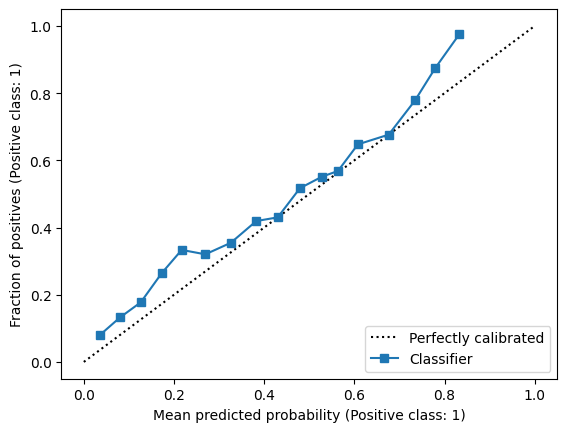

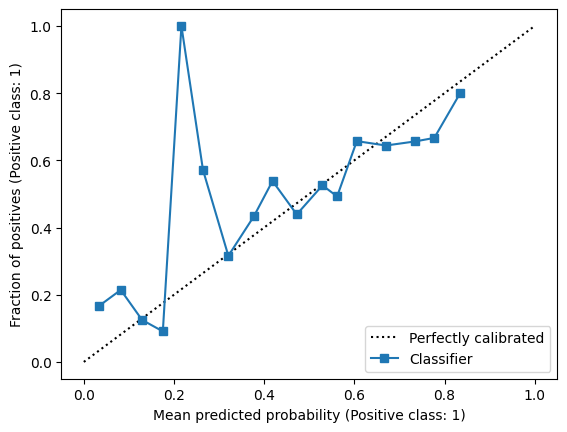

In [35]:
train_xgb_evals.display_calibration_curve(nbins=20)
test_xgb_evals.display_calibration_curve(nbins=20)

In [36]:
test_xgb_evals.get_accuracy(), test_xgb_evals.get_recall(), test_xgb_evals.get_precision(), test_xgb_evals.get_f1_score()

Expected Accuracy: 	0.6038
Compare Accuracy: 	0.5000
Expected Recall: 	0.7736
Compare Recall: 	1.0000
Expected Precision: 	0.5775
Compare Precision: 	0.5000
Expected F1 Score: 	0.6613
Compare F1 Score: 	0.6667


((0.6037735849056604, 0.5),
 (0.7735849056603774, 1.0),
 (0.5774647887323944, 0.5),
 (0.6612903225806451, 0.6666666666666666))

In [37]:
baseline_xgb_evals.get_confusion_matrix(), test_xgb_evals.get_confusion_matrix()

(array([[  0, 212],
        [  0, 212]]),
 array([[ 92, 120],
        [ 48, 164]]))

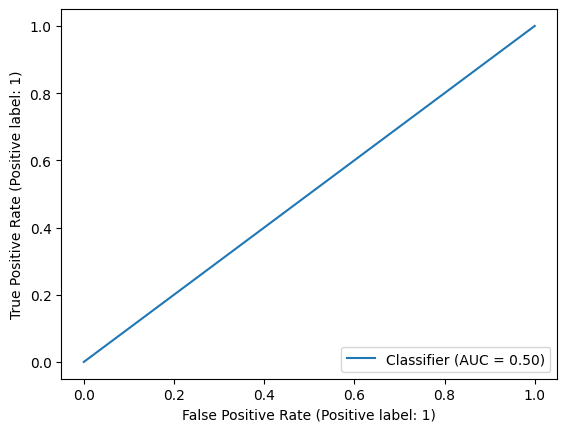

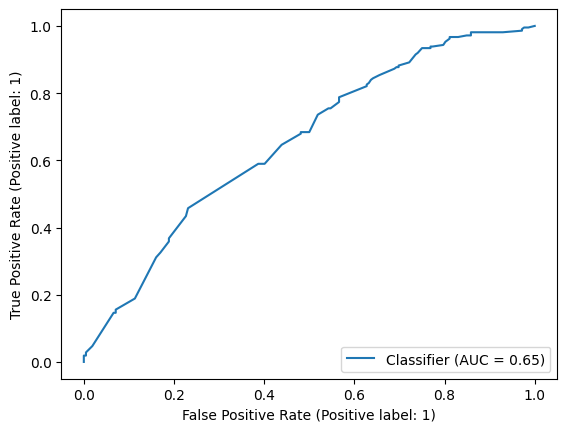

In [38]:
baseline_xgb_evals.plot_roc_curve()
test_xgb_evals.plot_roc_curve()

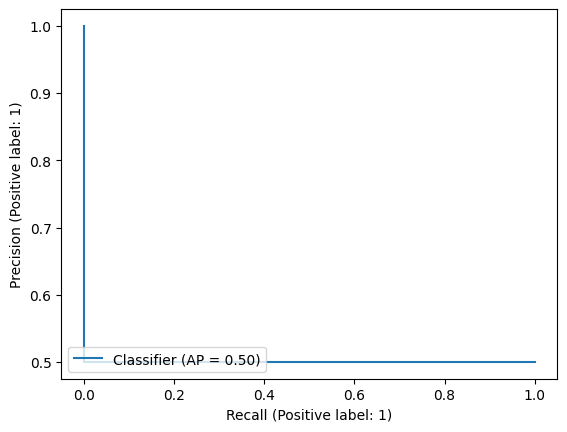

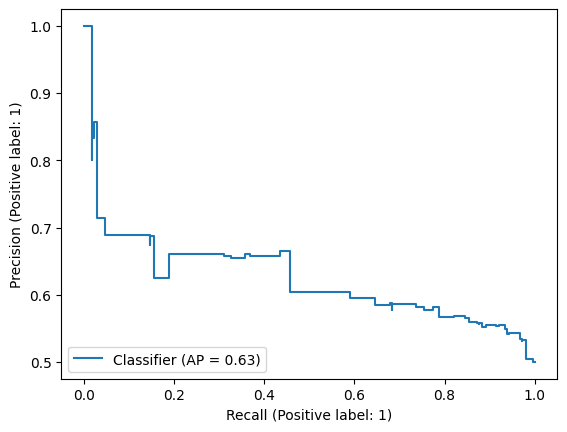

In [39]:
baseline_xgb_evals.plot_prauc_curve()
test_xgb_evals.plot_prauc_curve()

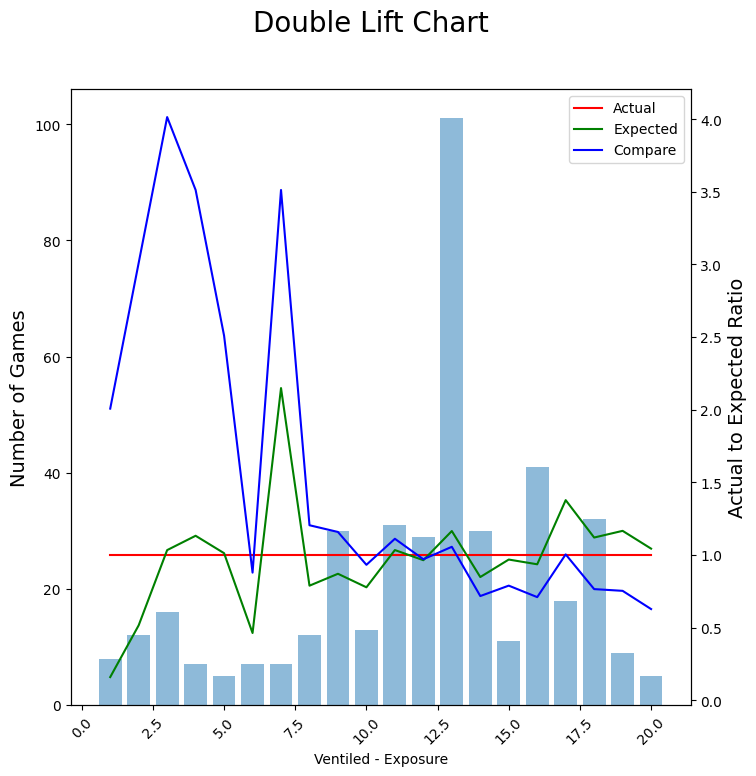

In [40]:
test_xgb_evals.plot_double_lift_chart()

Plots

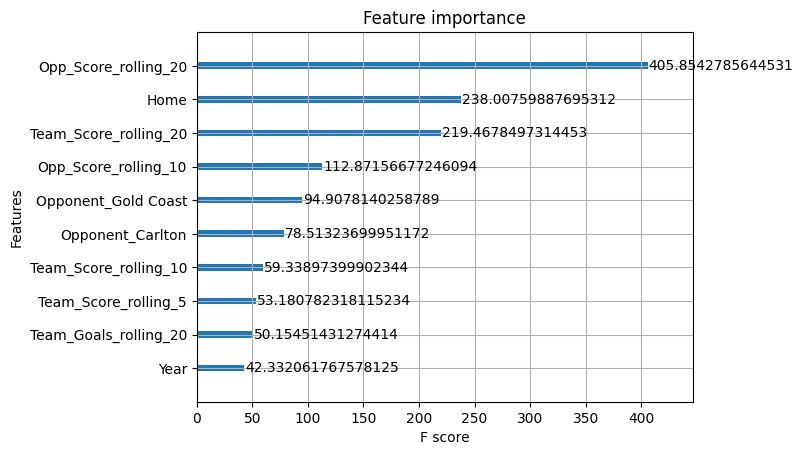

In [41]:
test_xgb_evals.plot_feature_importance(
    max_num_features=10, importance_type="total_gain"
)

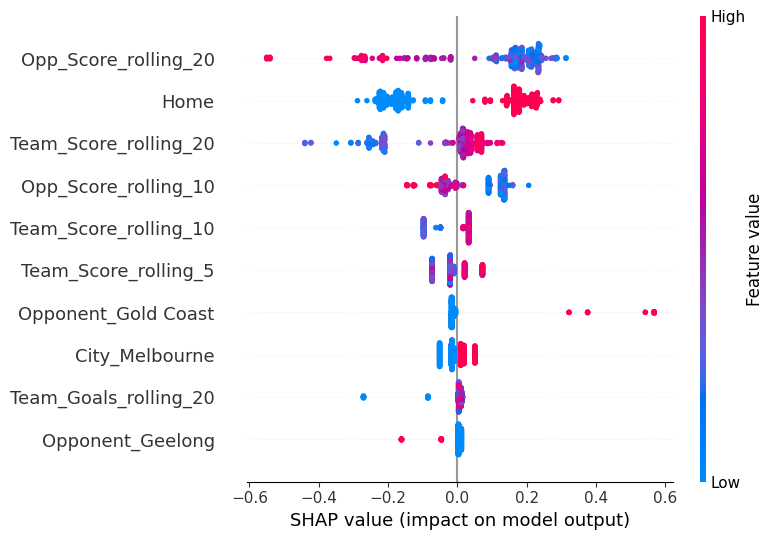

In [42]:
test_xgb_evals.plot_shap_summary_plot(sample=len(X_test))

In [43]:
top_features = test_xgb_evals.get_ranked_feature_importance()
top_10_features = top_features[:10]
top_10_features

['Opp_Score_rolling_20',
 'Home',
 'Team_Score_rolling_20',
 'Opp_Score_rolling_10',
 'Team_Score_rolling_10',
 'Team_Score_rolling_5',
 'Opponent_Gold Coast',
 'City_Melbourne',
 'Team_Goals_rolling_20',
 'Opponent_Geelong']

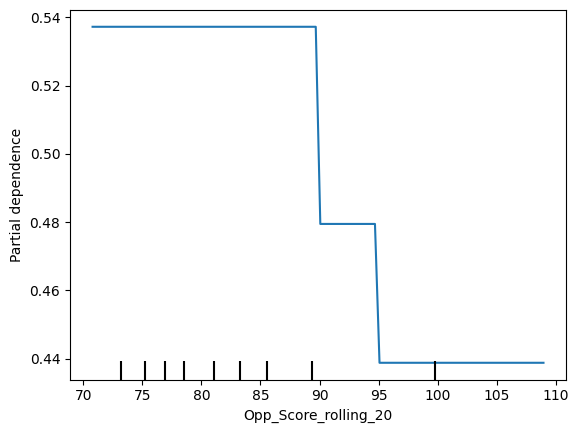

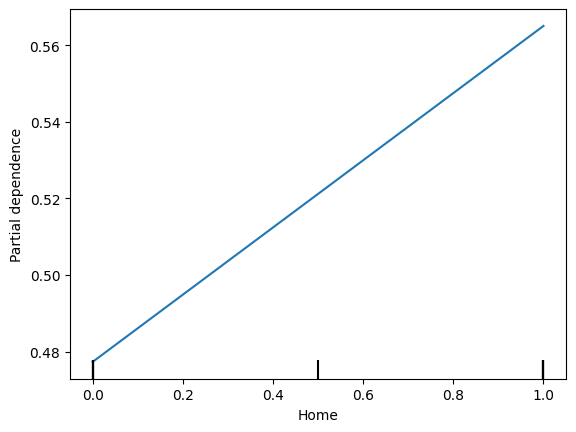

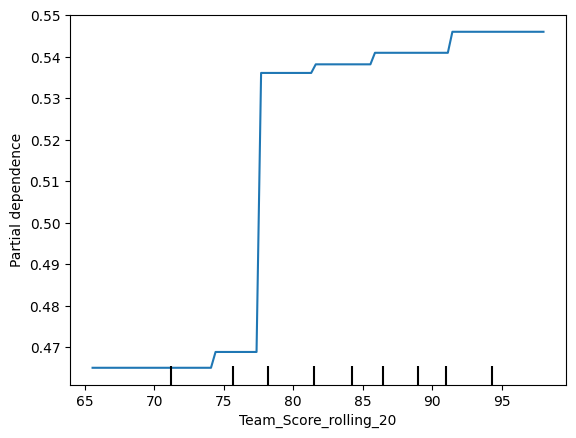

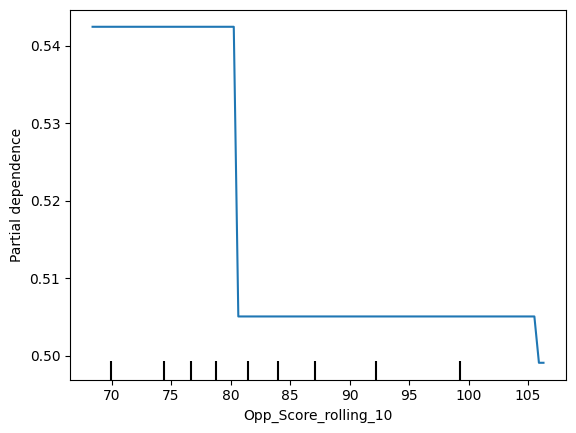

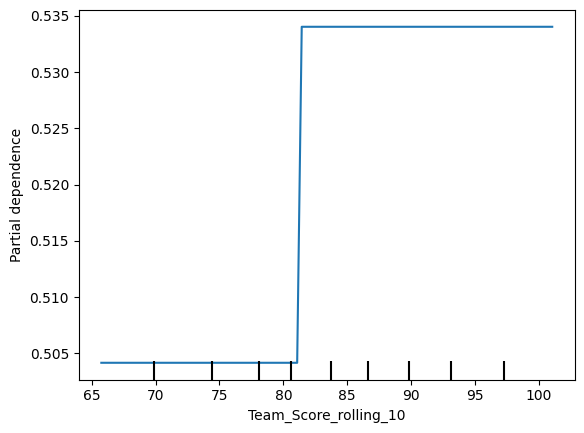

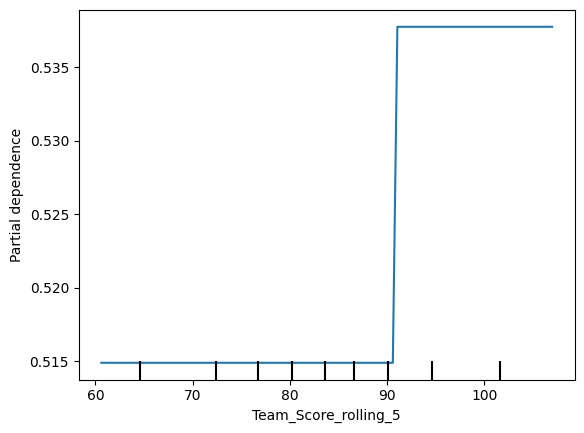

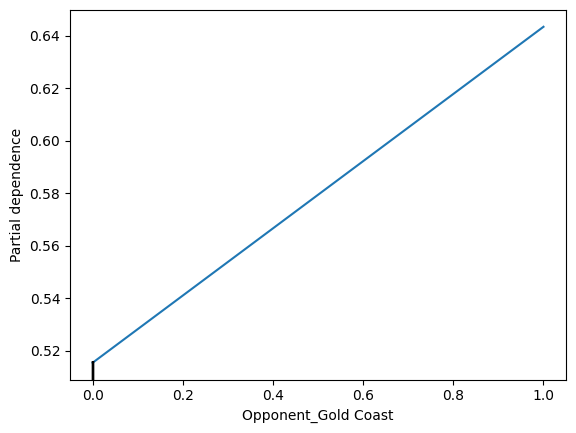

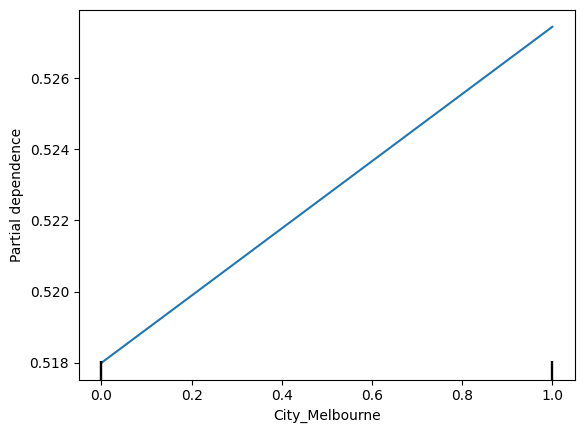

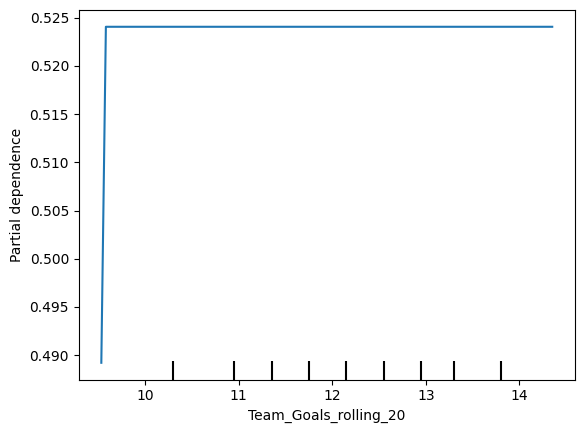

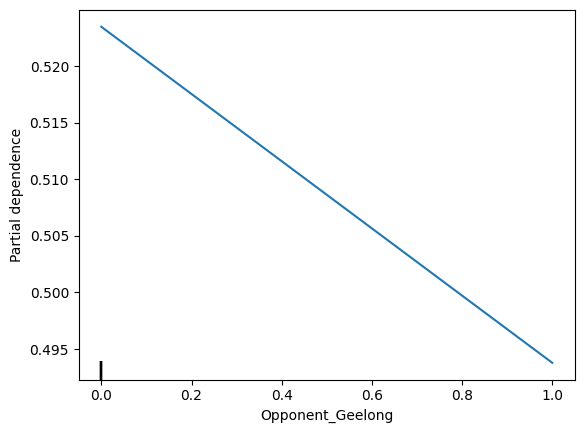

In [44]:
for col in top_10_features:
    # train_xgb_evals.plot_pdp([col])
    test_xgb_evals.plot_pdp([col])

In [45]:
# for col in top_10_features:
#     train_xgb_evals.plot_ice([col])
#     test_xgb_evals.plot_ice([col])

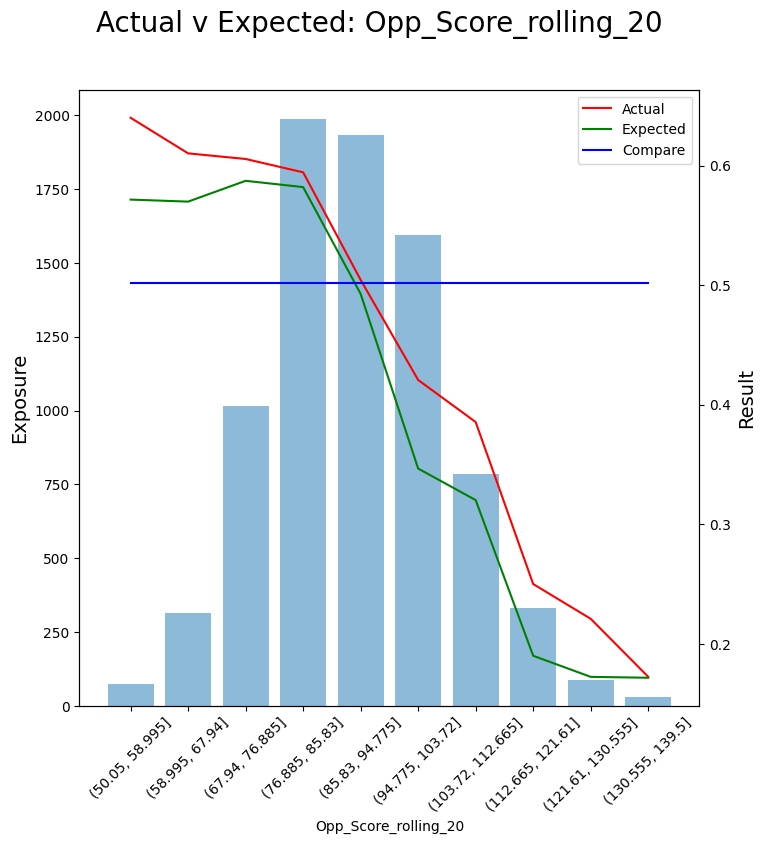

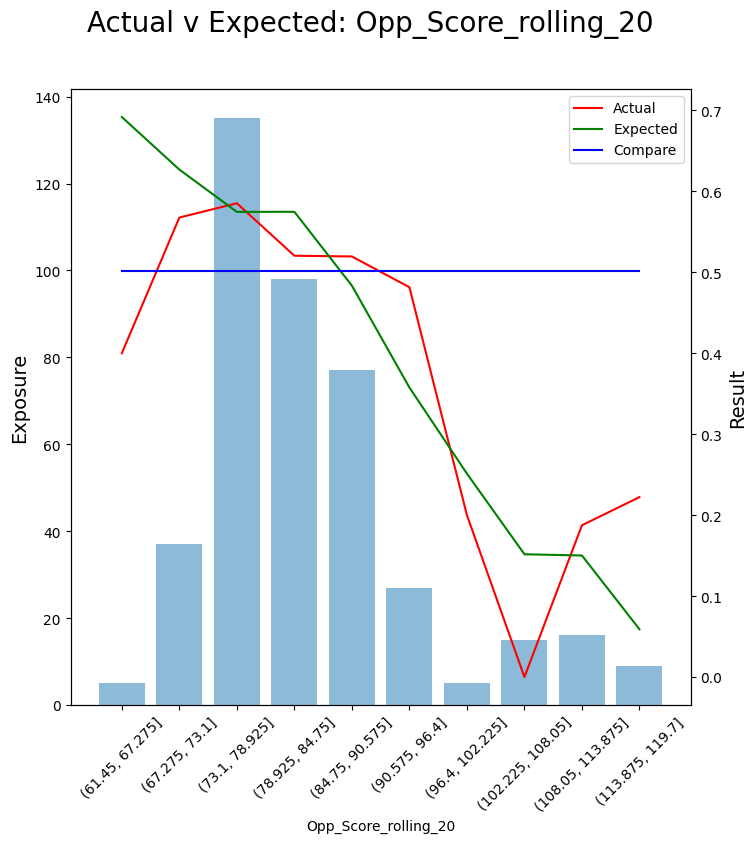

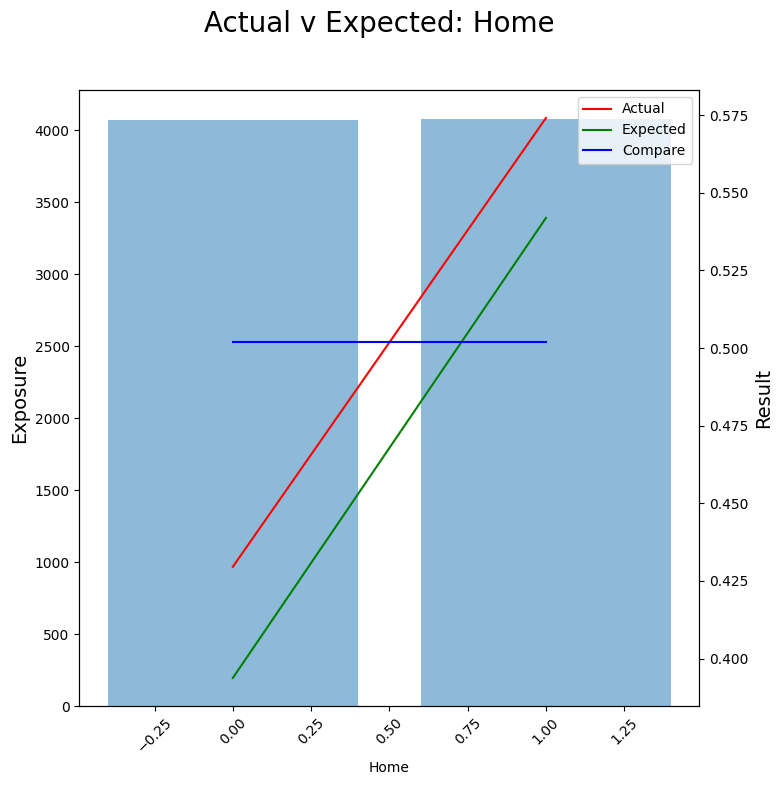

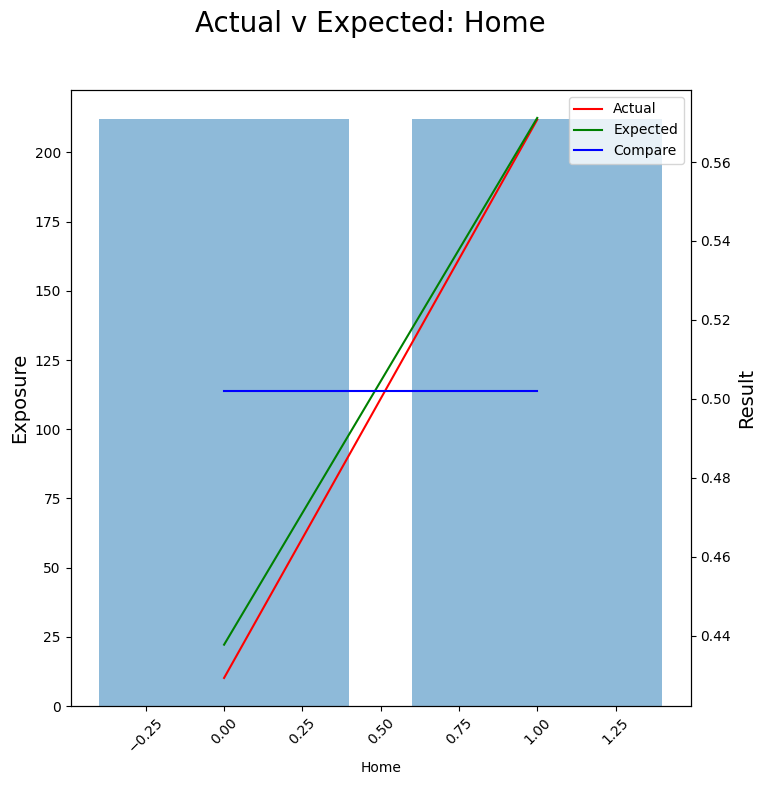

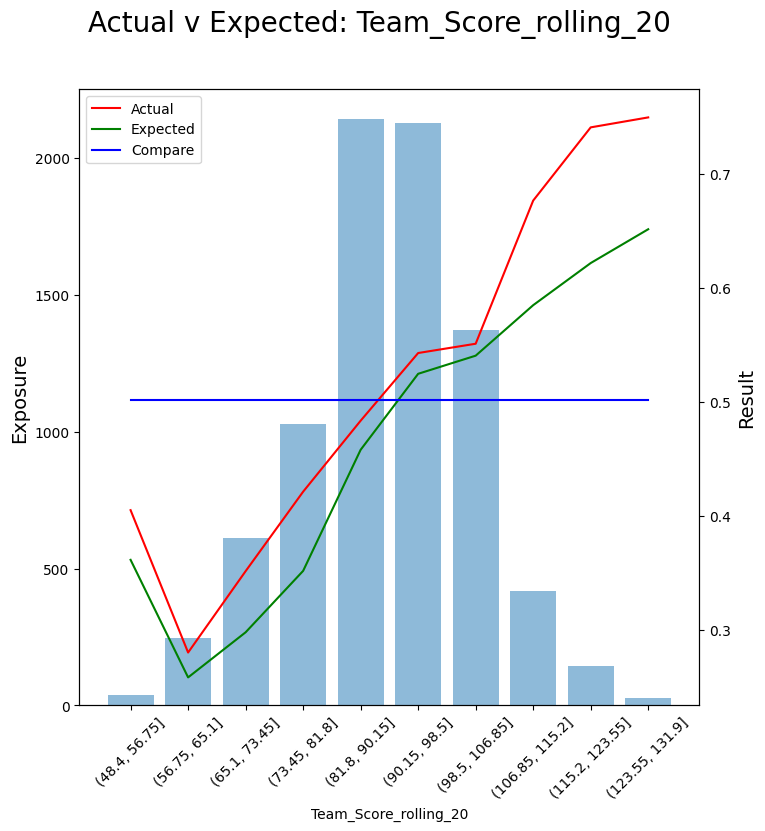

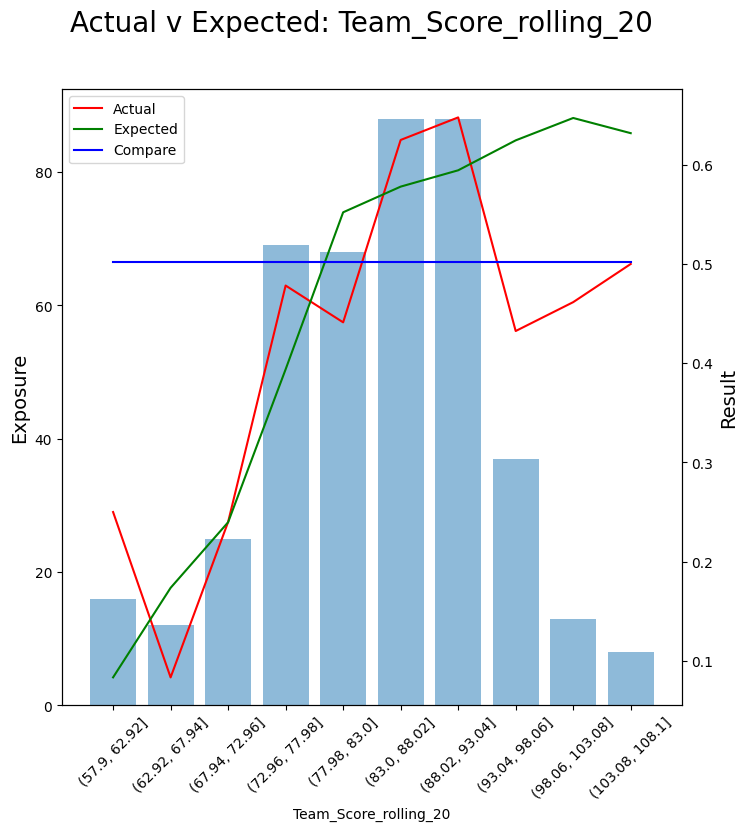

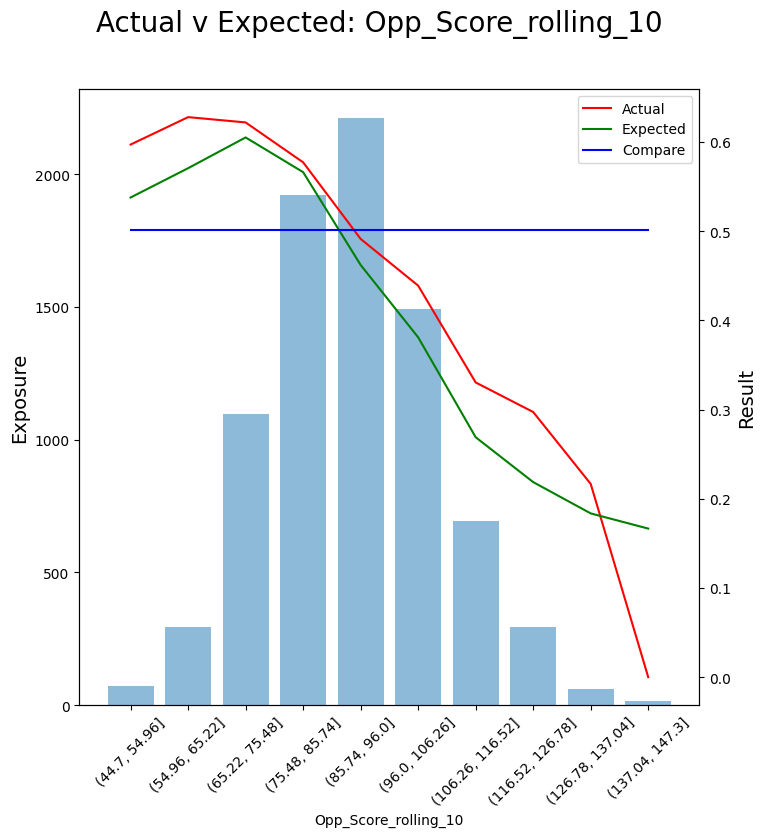

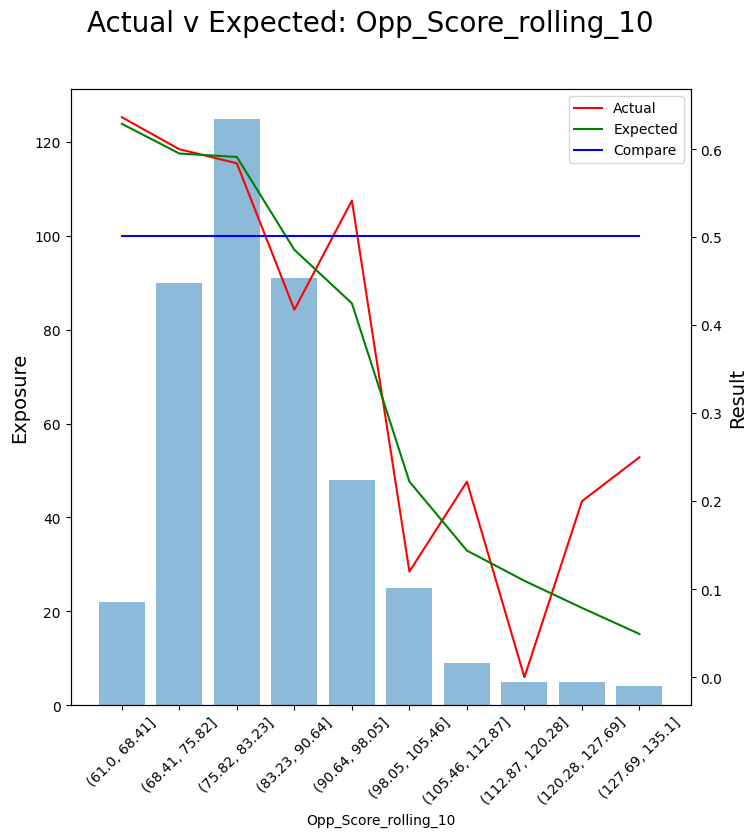

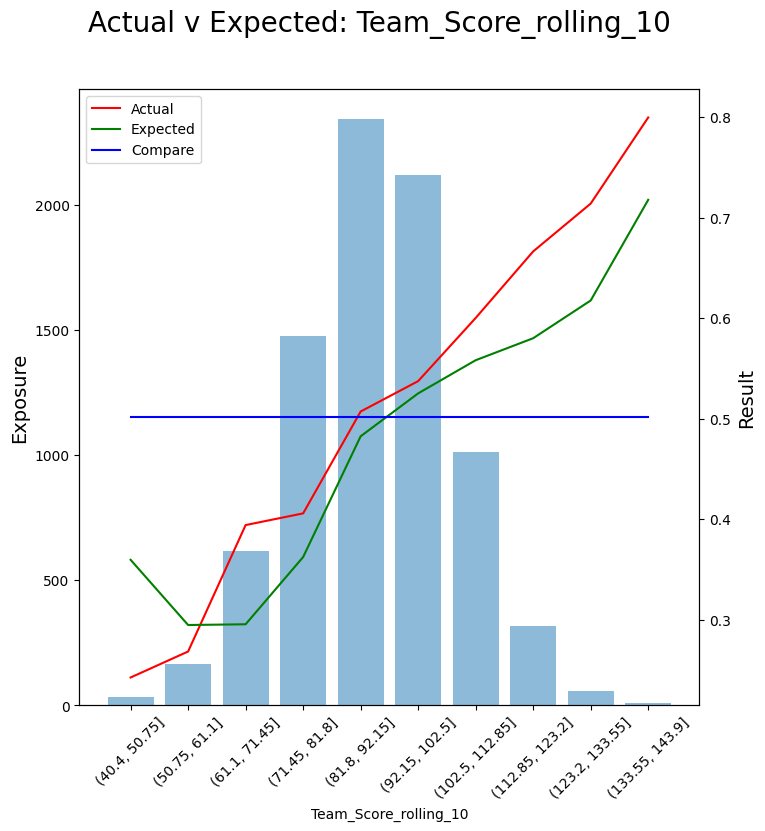

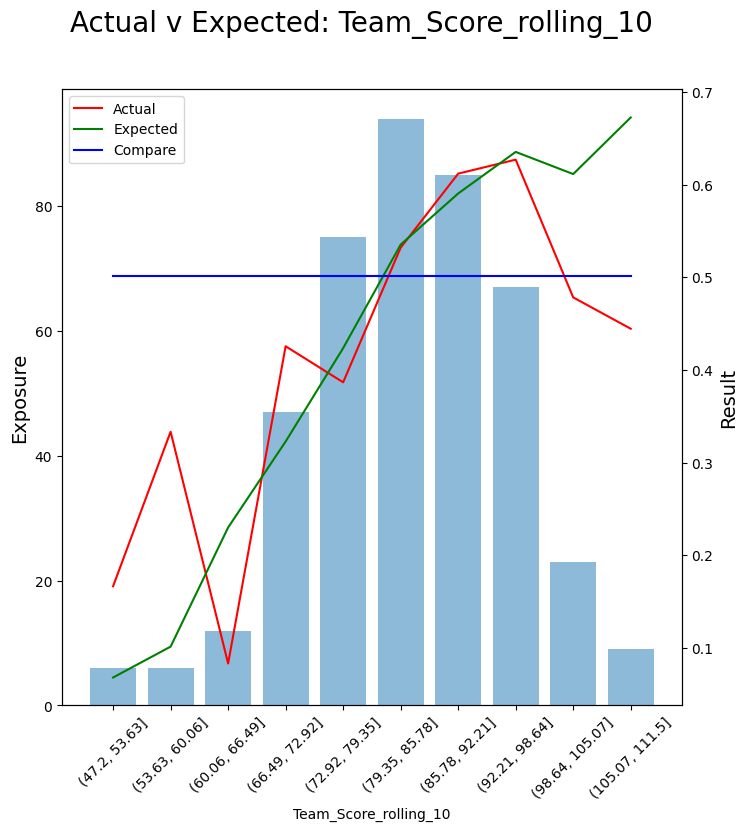

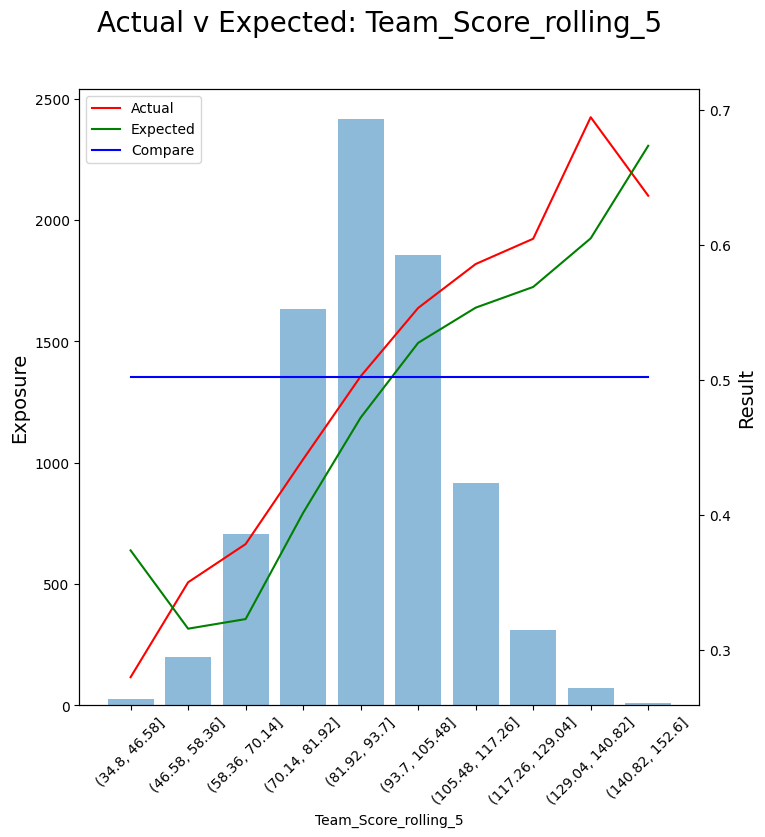

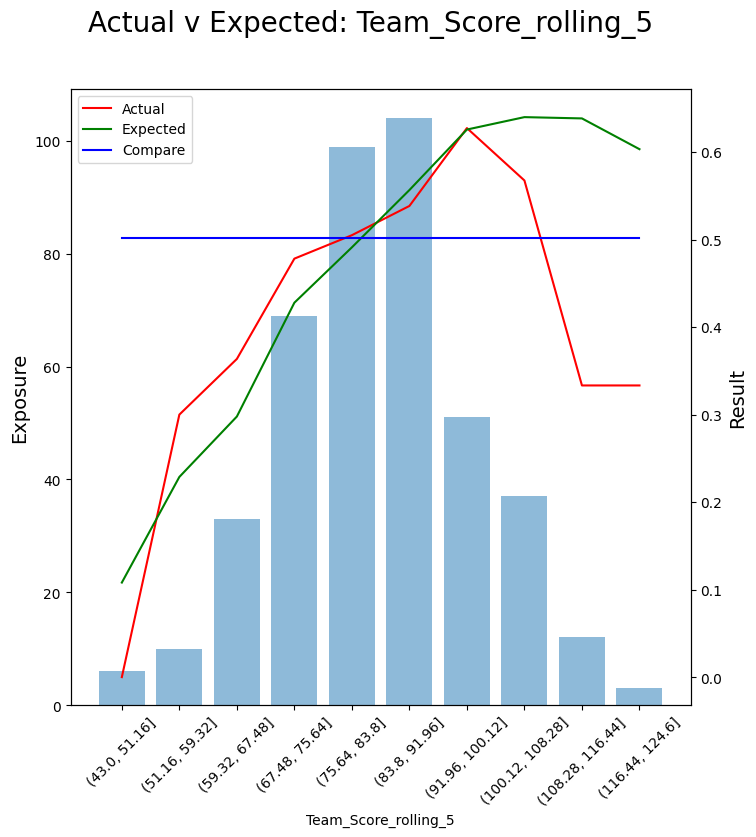

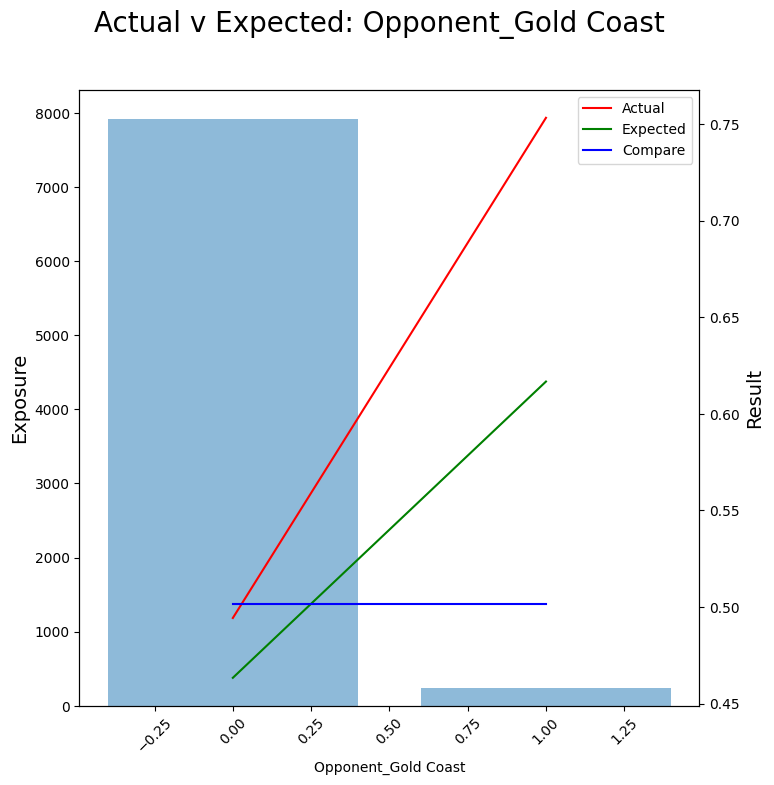

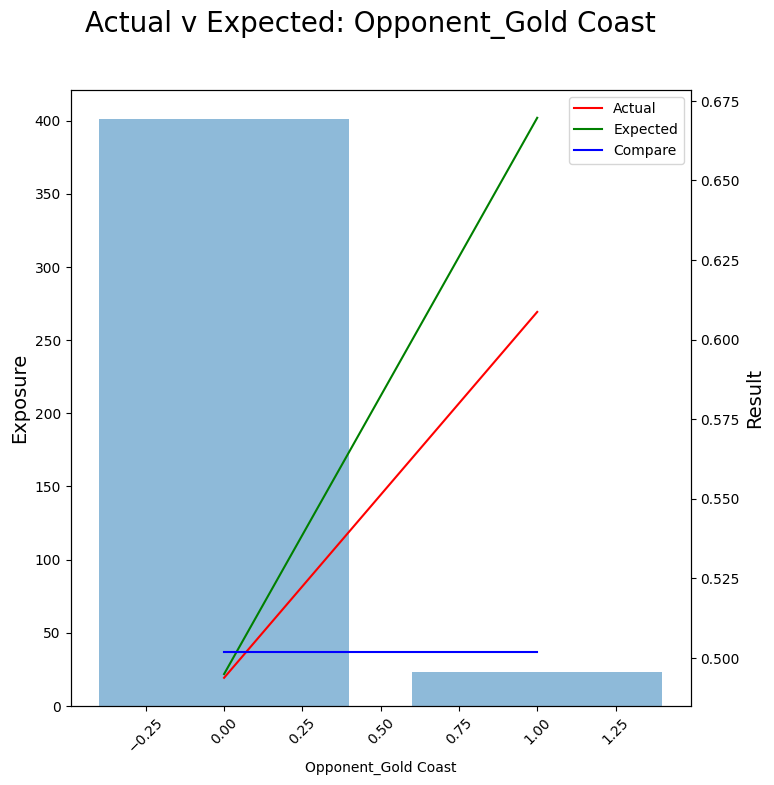

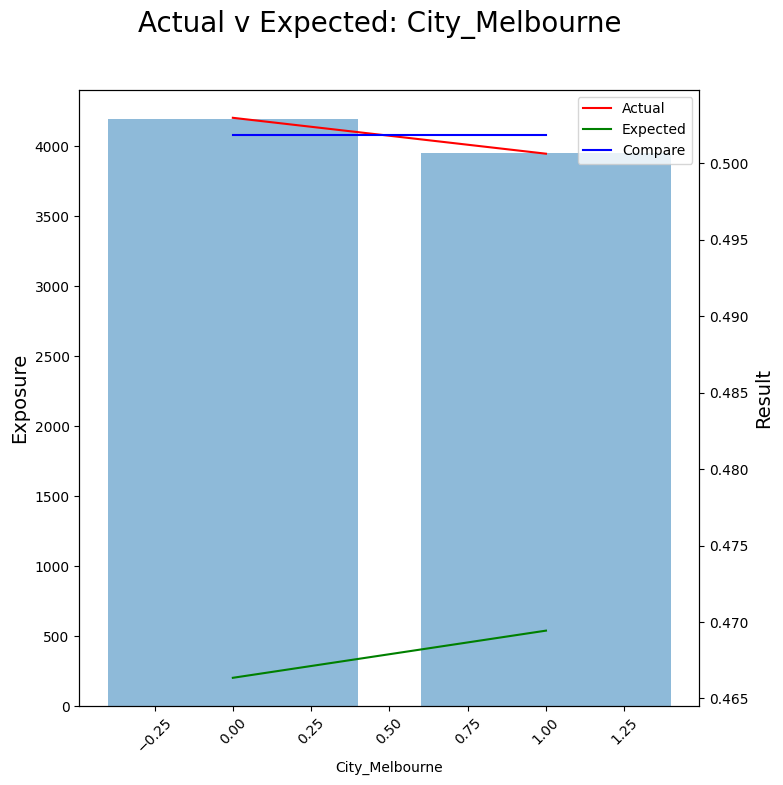

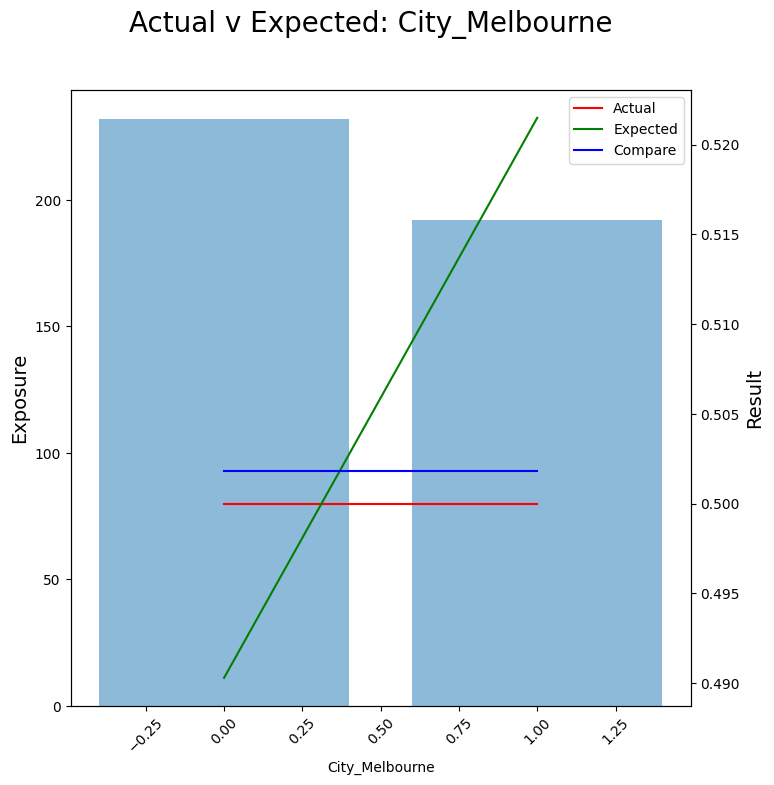

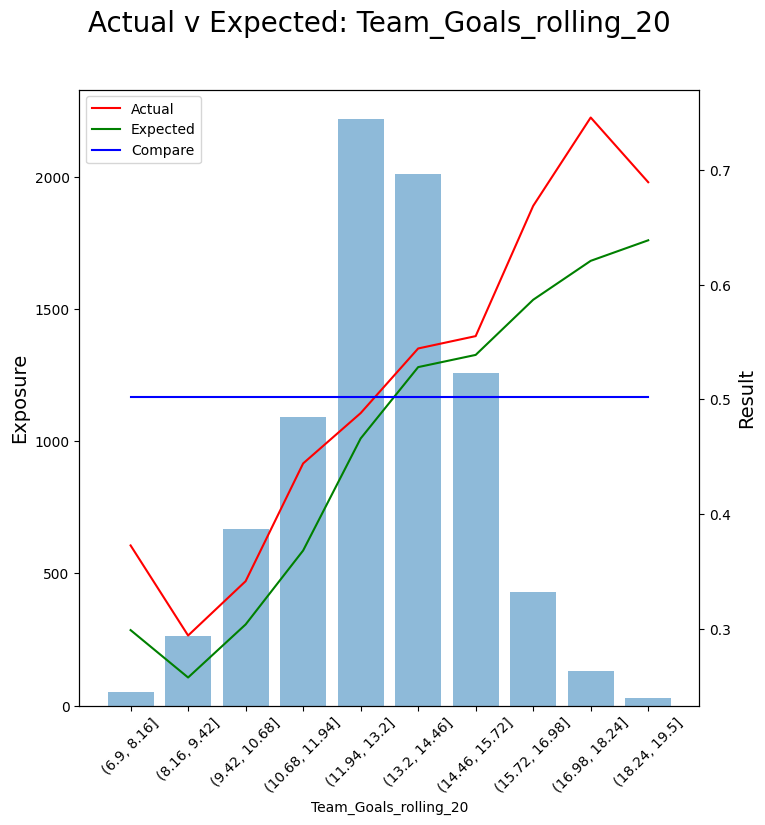

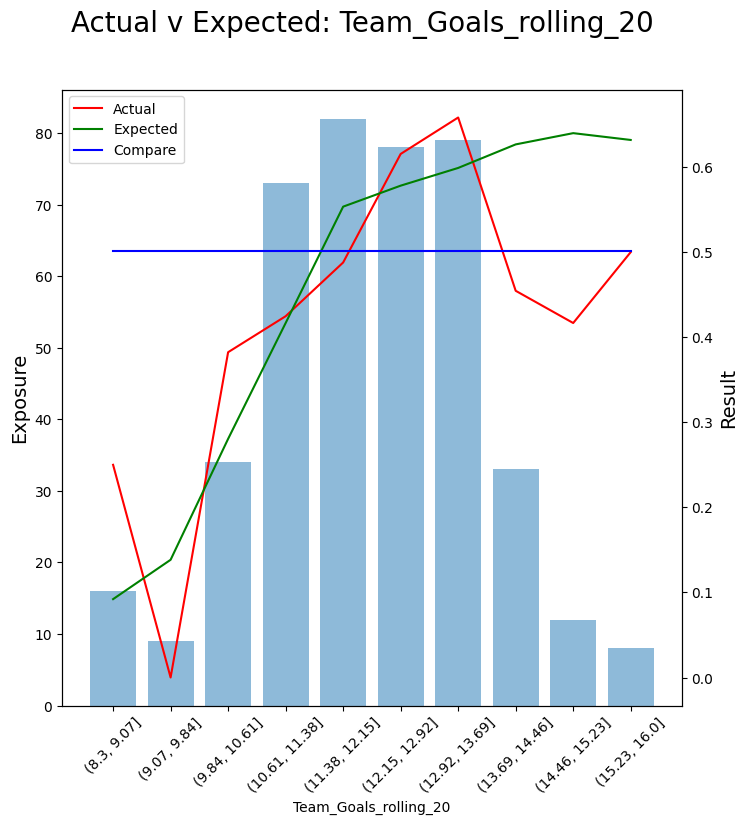

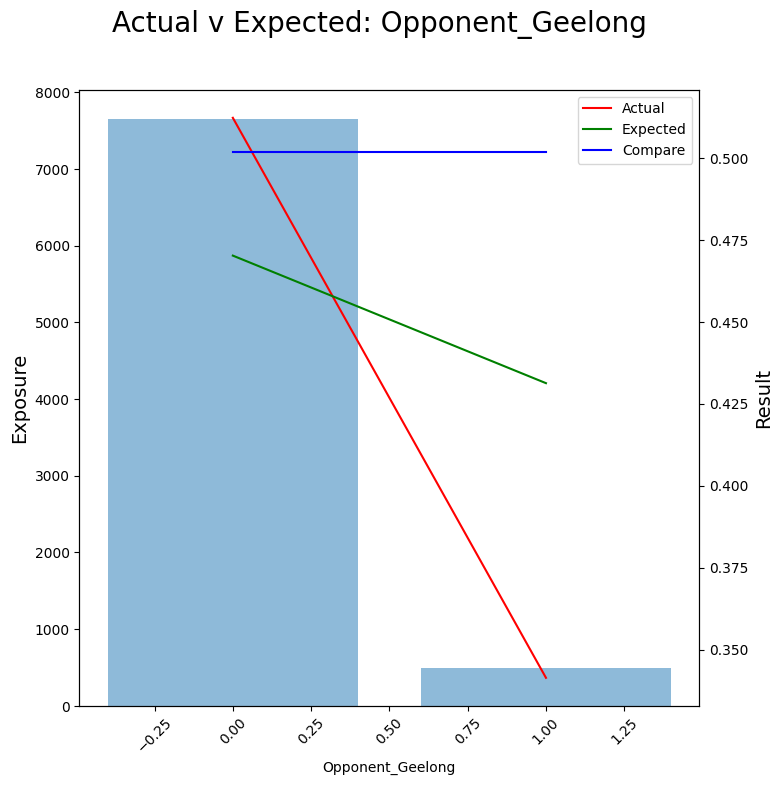

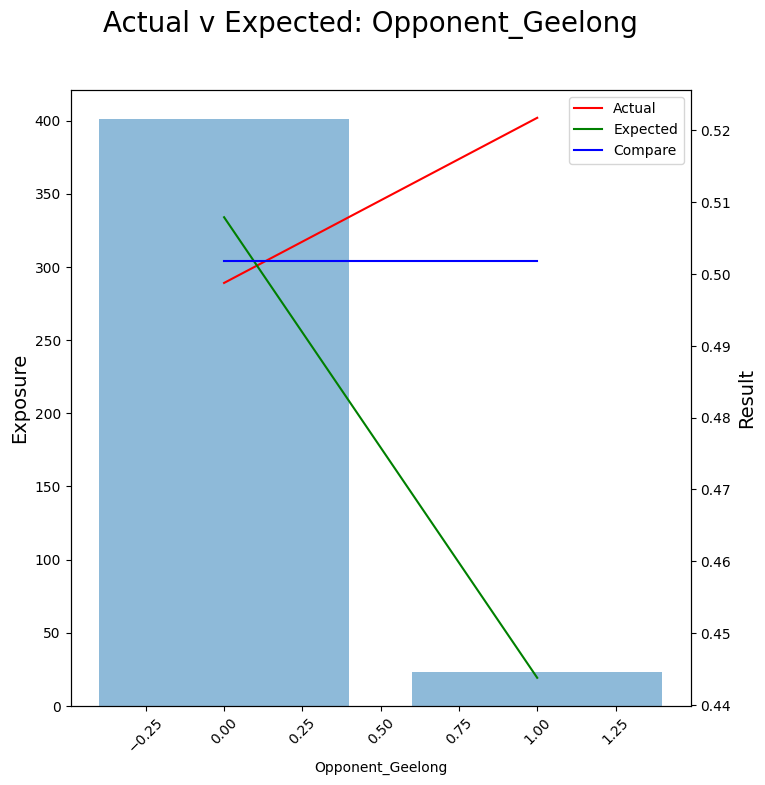

In [46]:
for col in top_10_features:
    train_xgb_evals.plot_feature_ave(col)
    test_xgb_evals.plot_feature_ave(col)

Export and Save Pipeline

In [47]:
joblib.dump(super_xgb, "/Users/ciaran/Documents/Projects/AFL/git-repositories/afl-match-outcome-model/model_outputs/cv_base_match_outcome_xgb.joblib")
joblib.dump(match_preprocessor, "/Users/ciaran/Documents/Projects/AFL/git-repositories/afl-match-outcome-model/model_outputs/cv_base_match_outcome_match_preprocessor.joblib")

['/Users/ciaran/Documents/Projects/AFL/git-repositories/afl-match-outcome-model/model_outputs/cv_base_match_outcome_match_preprocessor.joblib']

In [48]:
pipeline = Pipeline([
    ('preprocessor', match_preprocessor),
    ('model', super_xgb)
])
pipeline.predict_proba(data, calibrate=True).mean(), pipeline.predict_proba(data, calibrate=False).mean()

(0.47105308369306903, 0.5)

In [49]:
joblib.dump(pipeline, "/Users/ciaran/Documents/Projects/AFL/git-repositories/afl-match-outcome-model/model_outputs/cv_base_match_outcome_pipeline.joblib")

['/Users/ciaran/Documents/Projects/AFL/git-repositories/afl-match-outcome-model/model_outputs/cv_base_match_outcome_pipeline.joblib']